In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

crimes = pd.read_csv('../crimes.csv', index_col='Date Reported')
violations = pd.read_csv('finalviolations.csv', sep=',', index_col=0)

crimes.index = crimes.index.to_datetime()

In [3]:
list(crimes.columns)

['RMS CDW ID',
 'General Offense Number',
 'Offense Code',
 'Offense Code Extension',
 'Offense Type',
 'Summary Offense Code',
 'Summarized Offense Description',
 'Occurred Date or Date Range Start',
 'Occurred Date Range End',
 'Hundred Block Location',
 'District/Sector',
 'Zone/Beat',
 'Census Tract 2000',
 'Longitude',
 'Latitude',
 'Location',
 'Month',
 'Year']

In [4]:
crimes = crimes[['Summarized Offense Description','District/Sector','Latitude', 'Longitude']].dropna()
crimes = crimes[crimes['Latitude'] != 0.0]

In [5]:
crimes['District/Sector'].value_counts()

M     49262
K     45964
D     44781
U     44312
E     43359
B     40811
N     38837
J     36998
R     36209
Q     35953
L     35891
S     32155
W     31379
C     29715
F     29114
G     28112
O     22506
99     1197
H         2
dtype: int64

In [6]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Car prowl                           113755
Other property                       76345
Burglary                             66231
Property damage                      47299
Vehicle theft                        45338
Fraud                                35032
Assault                              34662
Warrant arrest                       32415
Threats                              21689
Disturbance                          20597
Stolen property                      19915
Shoplifting                          19906
Narcotics                            15117
Robbery                              13640
Bike theft                           10183
Trespass                              8245
Burglary-secure parking-res           5629
Traffic                               4178
Weapon                                3267
Lost property                         3152
Prostitution                          3026
Dispute                               2862
Mail theft                            2823
Pickpocket 

count       95.000000
mean      6595.336842
std       2801.083208
min          1.000000
25%       4408.000000
50%       5769.000000
75%       9075.000000
max      11994.000000
dtype: float64

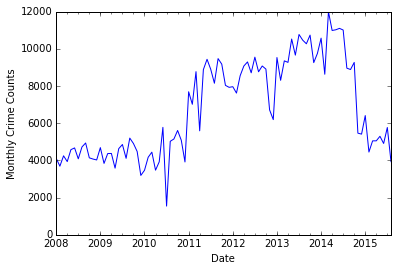

In [7]:
crime_counts = crimes.index.value_counts().resample('M', how='sum')
crime_counts['2008-01-01':].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

crime_counts.describe()

In [17]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [24]:
cases = pd.DataFrame({'Crime Counts': pd.Series(crime_counts, index=crime_counts.index),
                     'Daylight Hours': pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index),
                     'Weekday': pd.Series(crime_counts.index.dayofweek, index=crime_counts.index)})
cases = cases.fillna(0)
cases = cases['2008-01-01':]

In [33]:
from sklearn.linear_model import LinearRegression

x = cases[['Daylight Hours','Weekday']]
y = cases['Crime Counts']
fit = LinearRegression().fit(x,y)

cases['Trend1'] = fit.predict(x)
cases['Detrended1'] = cases['Crime Counts'] - cases['Trend1'] + cases['Trend1'].mean()

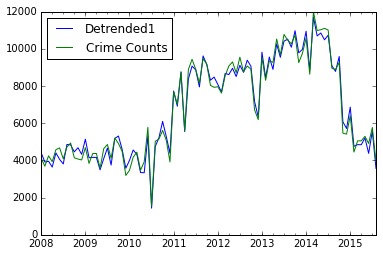

In [34]:
 cases[['Detrended1','Crime Counts']].plot()

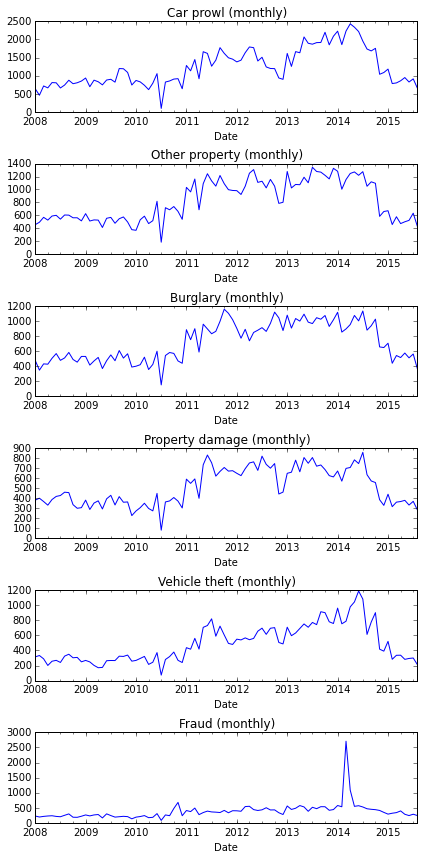

In [79]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(6)]

for i in range(6):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]) + ' (monthly)')
    axes[i].set_xlabel('Date')
fig.tight_layout()